# Payment Behaviour

In [10]:
# -------------------------------------------------------------------
# Setup cell — place this at the top of every analysis notebook
# -------------------------------------------------------------------
# Core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm

df = pd.read_csv("../datasets/customer_shopping_data_v10.csv")
sns.set_theme(style="whitegrid")

color1 = '#FF9E9D'  # Coral Pink
color2 = '#FFC785'  # Peach
color3 = '#FFF59D'  # Light Lemon
color4 = '#A0E6A6'  # Mint Green
color5 = '#87C8FF'  # Sky Blue
color6 = '#C4A2FF'  # Lavender

1. payment_method ↔ invoice_date <br>
What are the trends in payment method shares over time?

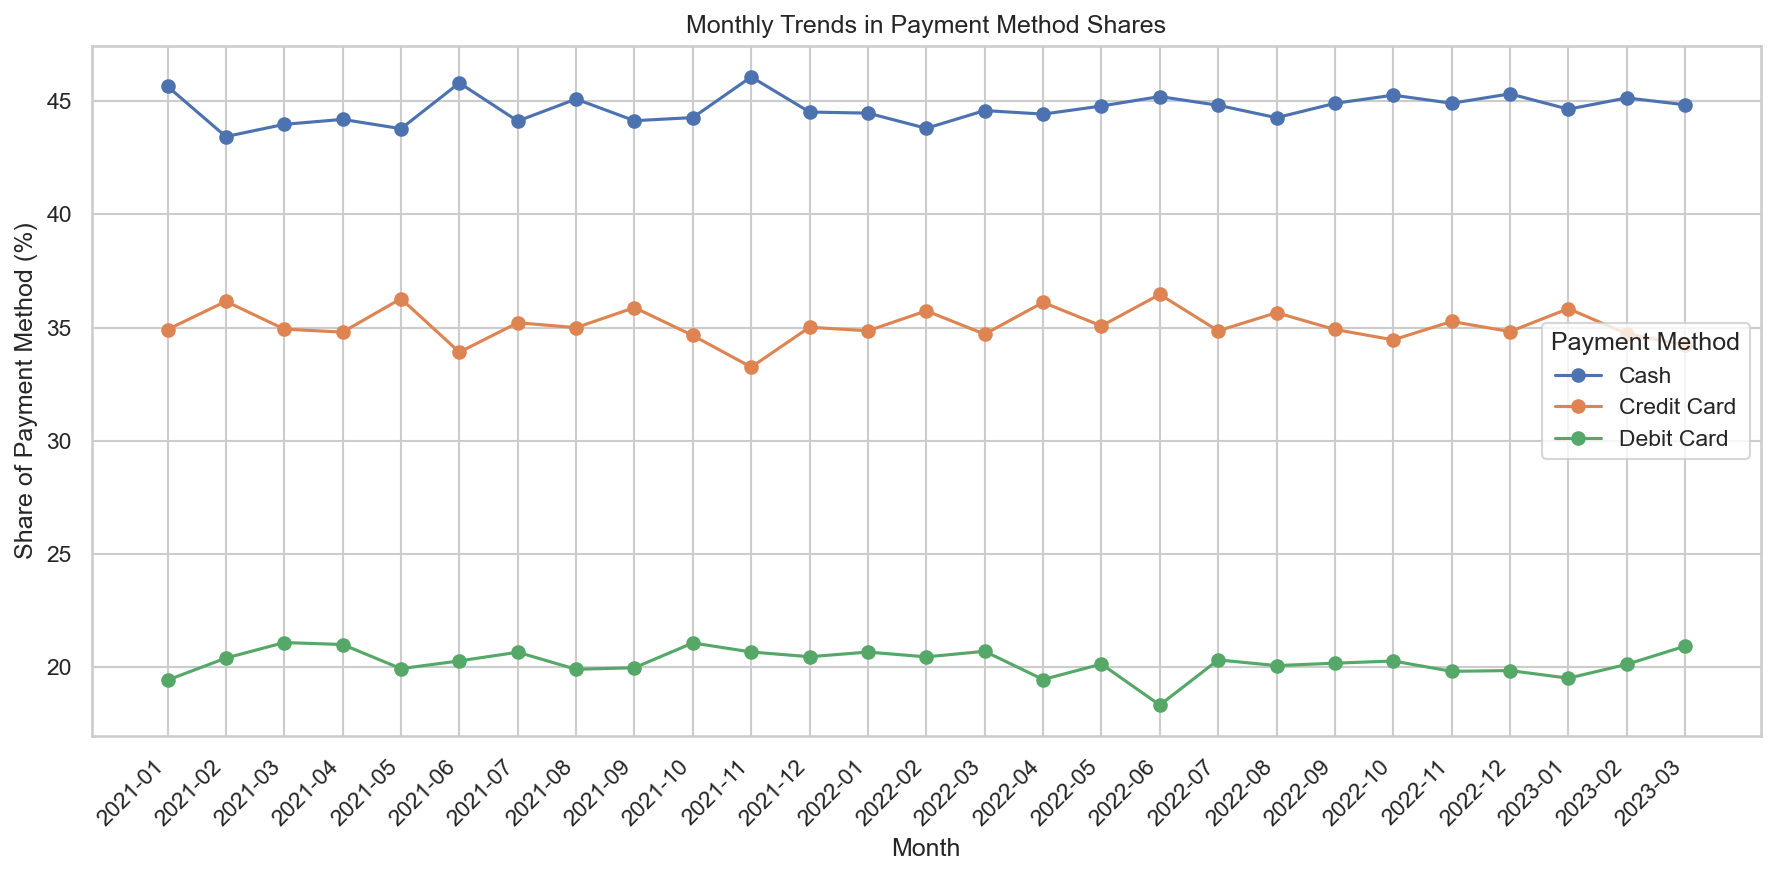


Payment Method: Cash
                            OLS Regression Results                            
Dep. Variable:                   Cash   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.268
Date:                Sat, 28 Jun 2025   Prob (F-statistic):              0.145
Time:                        10:15:43   Log-Likelihood:                -24.597
No. Observations:                  27   AIC:                             53.19
Df Residuals:                      25   BIC:                             55.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3629      0.2

In [4]:
# 1. Convert invoice_date to datetime
df["invoice_date"] = pd.to_datetime(df["invoice_date"])
df["year_month"] = df["invoice_date"].dt.to_period("M").astype(str)

# 2. Count transactions by payment method and month
payment_trends = (
    df.groupby(["year_month", "payment_method"])
      .size()
      .reset_index(name="transaction_count")
)

# 3. Calculate total transactions per month
monthly_totals = (
    payment_trends.groupby("year_month")["transaction_count"]
    .sum()
    .reset_index(name="total_transactions")
)

# 4. Merge totals back into main DataFrame
payment_trends = payment_trends.merge(
    monthly_totals,
    on="year_month"
)

# 5. Compute share percentage
payment_trends["share_percent"] = (
    payment_trends["transaction_count"] / payment_trends["total_transactions"] * 100
)

# 6. Pivot data for plotting and regression
pivot_df = payment_trends.pivot(
    index="year_month",
    columns="payment_method",
    values="share_percent"
).fillna(0)

# 7. Encode time as sequential integers
pivot_df = pivot_df.sort_index()
pivot_df["time_index"] = range(1, len(pivot_df)+1)

# 8. Plot line chart of payment method shares over time
plt.figure(figsize=(12,6), dpi=150)
for col in pivot_df.columns.drop("time_index"):
    plt.plot(
        pivot_df.index,
        pivot_df[col],
        marker='o',
        label=col
    )
plt.xlabel("Month")
plt.ylabel("Share of Payment Method (%)")
plt.title("Monthly Trends in Payment Method Shares")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Payment Method")
plt.tight_layout()
plt.show()

# 9. Fit linear regression for each payment method
for method in pivot_df.columns.drop("time_index"):
    y = pivot_df[method]
    X = pivot_df["time_index"]
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    coef = model.params["time_index"]
    p_value = model.pvalues["time_index"]

    print(f"\nPayment Method: {method}")
    print(model.summary())

    if p_value < 0.05:
        trend = "increasing" if coef > 0 else "decreasing"
        print(f"✅ Significant {trend} trend over time.")
    else:
        print("❌ No significant trend over time.")


2. payment_method ↔ gender <br>
How does payment method preference vary by gender?

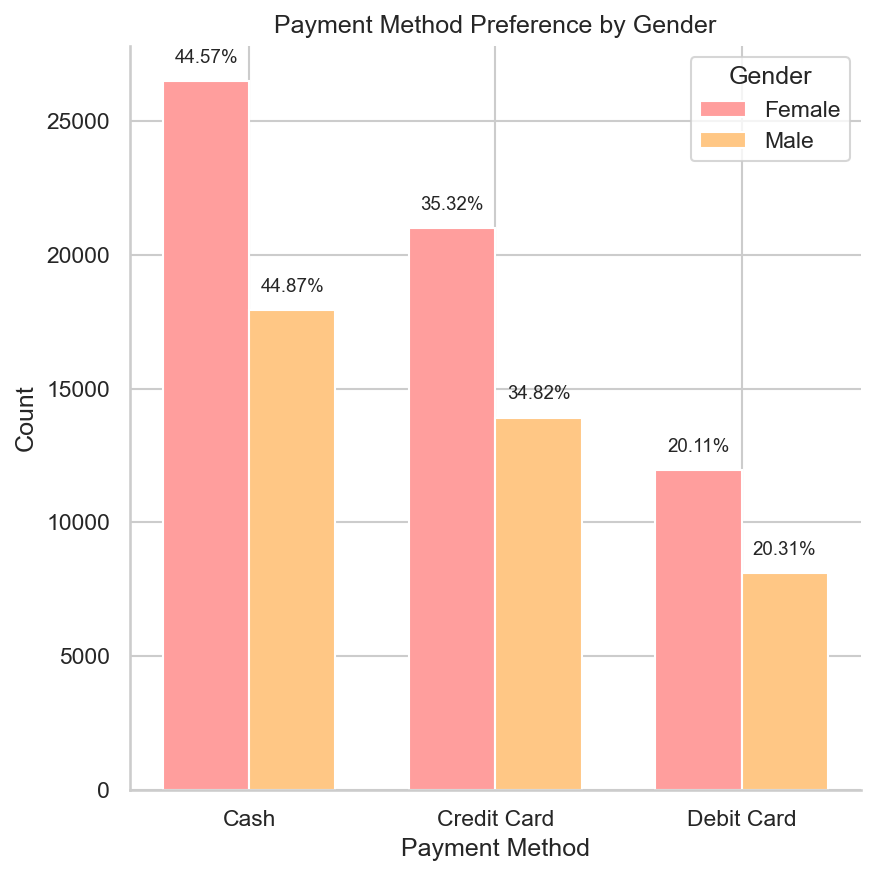


Observed counts:
gender          Female   Male
payment_method               
Cash             26509  17938
Credit Card      21011  13920
Debit Card       11962   8117

Expected counts under H0:
gender            Female      Male
payment_method                    
Cash            26582.31  17864.69
Credit Card     20891.10  14039.90
Debit Card      12008.60   8070.40
χ² = 2.6650  (df=2)   p-value = 0.2638
p = 0.2638 ≥ 0.05  →  Fail to reject H₀.
• Conclusion: No statistically significant association between gender and payment-method preference at the 95 % confidence level.


In [13]:
# -------------------------------------------------------------------
# Gender ↔ Payment Method  ─ grouped bars with count + % label
# -------------------------------------------------------------------
# Three payment methods on X-axis; for her/him bars side-by-side.
# Each bar shows the absolute count (height) and the share within
# that gender (text), rounded to 4 decimals.
# -------------------------------------------------------------------

# define two fixed colors for gender bars
gender_colors = {"Female": color1, 
                 "Male": color2}

# contingency table (rows = payment, cols = gender)
ct = pd.crosstab(df["payment_method"], df["gender"])

# total shoppers per gender → % share = count / gender_total
gender_tot = df["gender"].value_counts()
pct = ct.divide(gender_tot, axis=1) * 100  # percentage matrix

methods   = ct.index.tolist()
genders   = ct.columns.tolist()
x         = np.arange(len(methods)) 
width     = 0.35

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

for i, g in enumerate(genders):
    counts = ct[g].values
    ax.bar(x + i*width - width/2, counts,
           width=width, label=g, color =gender_colors[g])

    # annotate each bar with "count  (xx.xx %)"
    for j, c in enumerate(counts):
        perc = pct.iloc[j, i]
        ax.text(x[j] + i*width - width/2,
                c + max(ct.values.max()*0.02, 1),
                f"{perc:.2f}%",
                ha="center", va="bottom", fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel("Count")
ax.set_xlabel("Payment Method")
ax.set_title("Payment Method Preference by Gender")
ax.legend(title="Gender")
sns.despine()
plt.tight_layout()
plt.savefig("dataset_payment_behavior_figures/payment_gender_2.png", dpi=150)
plt.show()

# χ² test
chi2, p, dof, exp = stats.chi2_contingency(ct)

# Convert expected array to DataFrame with same labels
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

print("\nObserved counts:")
print(ct)

print("\nExpected counts under H0:")
print(expected_df.round(2))   # round to 2 decimals


print(f"χ² = {chi2:.4f}  (df={dof})   p-value = {p:.4f}")

# Interpretation (α = 0.05 ⇒ 95 % confidence level)
alpha = 0.05
if p < alpha:
    print(f"p = {p:.4f} < {alpha}  →  Reject H₀.")
    print("• Conclusion: Payment-method preference differs significantly by gender at the 95 % confidence level.")
else:
    print(f"p = {p:.4f} ≥ {alpha}  →  Fail to reject H₀.")
    print("• Conclusion: No statistically significant association between gender and payment-method preference at the 95 % confidence level.")


4. payment_method ↔ category <br>
Does payment method choice differ by product category?

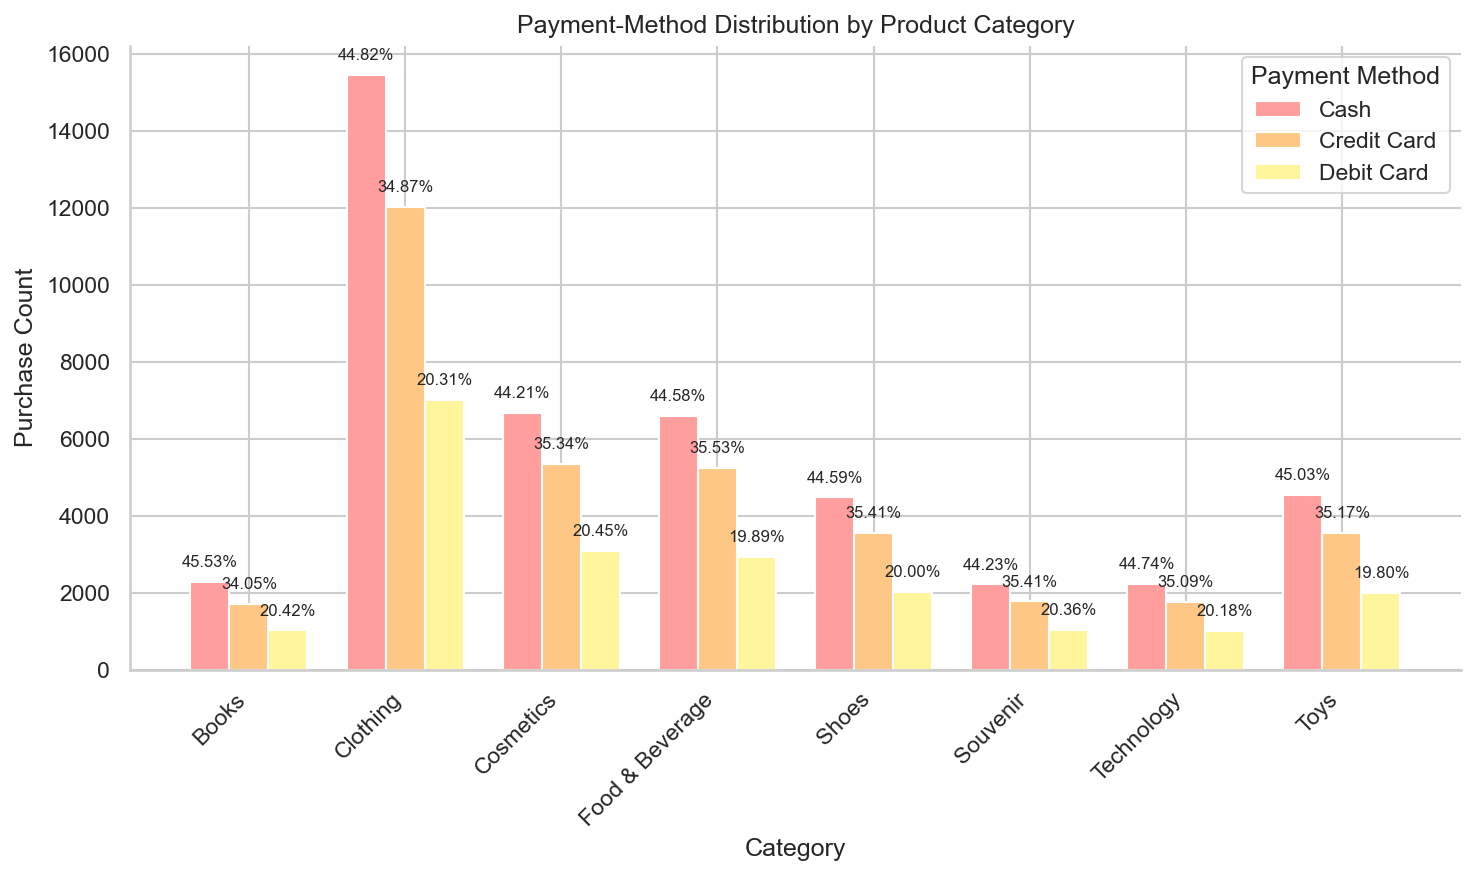


Observed counts:
payment_method    Cash  Credit Card  Debit Card
category                                       
Books             2268         1696        1017
Clothing         15456        12025        7006
Cosmetics         6674         5336        3087
Food & Beverage   6587         5250        2939
Shoes             4474         3553        2007
Souvenir          2211         1770        1018
Technology        2235         1753        1008
Toys              4542         3548        1997

Expected counts under H0:
payment_method       Cash  Credit Card  Debit Card
category                                          
Books             2225.99      1749.41     1005.60
Clothing         15412.12     12112.42     6962.45
Cosmetics         6746.80      5302.32     3047.88
Food & Beverage   6603.34      5189.58     2983.07
Shoes             4484.16      3524.11     2025.73
Souvenir          2234.04      1755.73     1009.23
Technology        2232.70      1754.68     1008.62
Toys            

In [14]:
# ╔══════════════════════════════════════════════════════════════╗
# ║ ANALYSIS: Does payment-method choice differ by product       ║
# ║          category?                                           ║
# ║ • Visual: For every category we draw exactly three bars—     ║
# ║   Cash, Credit-Card, Debit-Card—side-by-side.                ║
# ║ • Bars are annotated with count and the share (%) inside     ║
# ║   that category, rounded to 4 decimals.                      ║
# ║ • Test: χ² independence                                      ║
# ╚══════════════════════════════════════════════════════════════╝

# contingency table  rows = category   cols = payment method
ct = pd.crosstab(df["category"], df["payment_method"])

cats    = ct.index.tolist()
methods = ["Cash", "Credit Card", "Debit Card"]   # fixed order
x       = np.arange(len(cats))
width   = 0.25

method_colors = {"Cash": color1,      
                 "Credit Card": color2, 
                 "Debit Card": color3}  

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

for i, m in enumerate(methods):
    counts = ct[m].values
    bar_pos = x + (i - 1) * width          # centres the trio on each tick
    ax.bar(bar_pos, counts,
           width=width,
           color=method_colors[m],
           label=m)

    # annotate: count + percentage within the category
    pct = (counts / ct.sum(axis=1).values) * 100
    for j, (c, pcent) in enumerate(zip(counts, pct)):
        ax.text(bar_pos[j],
                c + max(ct.values.max()*0.02, 1),
                f"{pcent:.2f}%",
                ha="center", va="bottom", fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(cats, rotation=45, ha="right")
ax.set_ylabel("Purchase Count")
ax.set_xlabel("Category")
ax.set_title("Payment-Method Distribution by Product Category")
ax.legend(title="Payment Method")
sns.despine()
plt.tight_layout()
plt.savefig("dataset_payment_behavior_figures/payment_category_4.png", dpi=150)
plt.show()

# χ² test of independence
chi2, p, dof, exp = stats.chi2_contingency(ct)

# Convert expected array to DataFrame with same labels
expected_df = pd.DataFrame(exp, index=ct.index, columns=ct.columns)

print("\nObserved counts:")
print(ct)

print("\nExpected counts under H0:")
print(expected_df.round(2))   # round to 2 decimals


print(f"χ² = {chi2:.4f}  (df = {dof})   p-value = {p:.4f}")

alpha = 0.05
if p < alpha:
    print("At the 95 % confidence level, product category does influence payment-method choice.")
else:
    print("At the 95 % confidence level, there is no statistically significant association between product category and payment-method choice.")


5. payment_method ↔ basket_total_price <br>
Which payment methods are used for high-value baskets?

In [18]:
import statsmodels.api as sm
import pandas as pd

# Ensure payment_method is categorical
df["payment_method"] = df["payment_method"].astype("category")
df["payment_method_code"] = df["payment_method"].cat.codes

# Display mapping for reference
print("Category mapping:")
for code, label in enumerate(df["payment_method"].cat.categories):
    print(f"{code}: {label}")

# Create exog (predictor matrix) with constant
X = sm.add_constant(df["total_price"])

# Create endog (response)
y = df["payment_method_code"]

# Fit the model
model = sm.MNLogit(y, X).fit()

# Print regression summary
print(model.summary())

# Interpret each outcome category
params = model.params
pvalues = model.pvalues

# Payment method labels
labels = list(df["payment_method"].cat.categories)

# Remember: code 0 is baseline (Cash), 1 is Credit Card, 2 is Debit Card
mapping = {
    0: labels[0],
    1: labels[1],
    2: labels[2]
}

for col in params.columns:
    coef = params.loc["total_price", col]
    pval = pvalues.loc["total_price", col]
    label = mapping[col]

    print(f"\nPayment Method (vs Cash): {label}")
    if pval < 0.05:
        trend = "more likely" if coef > 0 else "less likely"
        print(f"✅ Significant: Higher basket value makes this payment method {trend}. (p={pval:.4f})")
    else:
        print(f"❌ Not significant: No strong association with basket value. (p={pval:.4f})")



Category mapping:
0: Cash
1: Credit Card
2: Debit Card
Optimization terminated successfully.
         Current function value: 1.050465
         Iterations 5
                           MNLogit Regression Results                          
Dep. Variable:     payment_method_code   No. Observations:                99457
Model:                         MNLogit   Df Residuals:                    99453
Method:                            MLE   Df Model:                            2
Date:                 Sat, 28 Jun 2025   Pseudo R-squ.:               2.075e-06
Time:                         10:23:35   Log-Likelihood:            -1.0448e+05
converged:                        True   LL-Null:                   -1.0448e+05
Covariance Type:             nonrobust   LLR p-value:                    0.8051
payment_method_code=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  